# Dependencies

In [1]:
#%% dependencies
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt

# ML and AI
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.optimizers import Adam

# Custom LSTM Model + LRP
from LSTM import *
from Preprocessing import process_data_with_factors, prepare_data_for_training

# Plotting and Graphs
import plotly.graph_objects as go

2023-08-09 19:42:13.327630: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 19:42:13.376277: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 19:42:13.376924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 19:42:14.315813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Fama French - Data Preparation 

In [3]:
# read in factor data as pd.dataframe
factors = pd.read_csv("./data/PredictorLSretWide.csv")

# format date column
factors["date"] = pd.to_datetime(factors["date"])

# filter factors for relevant period
factors = factors.loc[ factors['date'] >= pd.to_datetime('1990-01-01'), : ]  

# read in factor data as pd.dataframe
factors = pd.read_csv("./data/F-F_Research_Data_Factors.CSV", delimiter=",", skiprows=3, nrows=1163)

# rename the Date column
factors.rename(columns={factors.columns[0]: 'Date'}, inplace=True)

# convert Date column to datetime object with pandas
factors["Date"] = pd.to_datetime(factors["Date"],format="%Y%m")

# Download stock data for Apple (AAPL)
aapl = yf.download('AAPL', start='1990-01-01', end='2023-06-01')

# Download stock data for the SP500 etf SPX
sp500 = yf.download('^SPX', start='1990-01-01', end='2023-06-01')

# Resample to monthly frequency and calculate monthly returns
aapl = aapl["Adj Close"].resample('M').last().pct_change().reset_index()
sp500 = sp500["Adj Close"].resample('M').last().pct_change().reset_index()

# Merge the AAPL Series and the factors DataFrame based on the index
aapl_with_factors = pd.merge(aapl, factors[['Mkt-RF', 'SMB', 'HML']], left_index=True, right_index=True, how='left')

# Set the index back to the original date index
aapl = aapl_with_factors.set_index('Date')

# Merge the SP500 Series and the factors DataFrame based on the index
sp500_with_factors = pd.merge(sp500, factors[['Mkt-RF', 'SMB', 'HML']], left_index=True, right_index=True, how='left')

# Set the index back to the original date index
sp500 = sp500_with_factors.set_index('Date')

aapl.rename(columns={"Adj Close": "Return"}, inplace=True)
sp500.rename(columns={"Adj Close": "Return"}, inplace=True)

# clean up
del sp500_with_factors, aapl_with_factors

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Pre-Processing

After the data preperation is done, we can continue with

* splitting the data into train and test set

* scaling the data to ensure that all variables (predictor and response) are on the same scale

* re-shaping the data into a time series format that is suitable for the `tensorflow` LSTM network interface


In [ ]:

# Define the data to train on
data = sp500

# Drop rows with NaN values introduced by shifting
data.dropna(inplace=True)


# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Define X, y
X = data.drop(columns="Return").values
y = data["Return"].values

# ToDo: Normalise the Features and Response 

# Define the window size for one batch of data 
small_window_size = 5

# Create input sequences and response
sequences = []
response  = []

for i in range(small_window_size, len(X)):
    sequences.append(X[i-small_window_size:i])
    response.append(y[i])

# Convert the lists to numpy arrays
sequences = np.array(sequences)
labels = np.array(response)

# Double check if batches were created correctly
#print(sequences[0])
#print(X[:window_size])

split_ratio = 1

split_index = int(split_ratio * len(sequences))

X_train = sequences[:split_index]
y_train = labels[:split_index]
X_test = sequences[split_index:]
y_test = labels[split_index:]

## Rolling Regression with LSTM model

In [ ]:
# Define the model
model = LSTMModel(50,3,5)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit rolling lstm model
predictions, relevance = model.rolling_fit(X_train, y_train, 60, 1/60, 5)

In [ ]:
model.mse

## LRP for our LSTM model

In [ ]:
relevance_aggregated = np.mean(np.array(relevance), axis=1)

#plt.bar(height=np.abs(relevance_aggregated),x=["F1", "F2", "F3"])

from sklearn.preprocessing import scale


plt.plot(scale(relevance_aggregated), label=["F1", "F2", "F3"])
#plt.plot(y, label="response")
plt.legend()


---

# Deep Factor Model 

In [2]:
# Define Path to File with factors
file_path = "./data/PredictorLSretWide.csv"

# Define which factor variables to use
factor_selection = ["betaVIX",
                "Beta",
                "ReturnSkew",
                "RoE",
                "roaq",
                "Accruals",
                "Leverage",
                "Mom12m",
                "SP",
                "EP",
                "AM",
                "cfp",
                "Illiquidity"]

# Produce a data set that includes all factors and the returns
sp500 = process_data_with_factors(file_path, factor_selection)

# Take the data frame and compute a data set of batches of size corresponding to a rolling time-step window of 5
X_train, y_train, X_test, y_test = prepare_data_for_training(data=sp500, small_window_size=5, split_ratio=1)

# Fit rolling lstm model
predictions, relevance = rolling_fit(X_train, y_train, 60, 1/60, 5)

# Compute mse
mse = np.mean((predictions - y_train[60:])**2)

print("The MSE of the model:\t", mse)

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/363 [00:00<?, ?it/s]2023-08-09 19:42:57.273208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-09 19:42:57.275853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-09 19:42:57.277497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore t

KeyboardInterrupt: 

In [19]:
print(len(predictions), len(y_train[60:]))

363 363


In [3]:
print("The MSE of the model:\t", mse)

NameError: name 'mse' is not defined

In [3]:

np.mean(y_train[60:]**2)

0.9193112278273102

In [2]:
# Aggregate and Plot relevance over time

# Aggregate the relevance scores for all timesteps by taking the average
relevance_aggregated = np.mean(np.array(relevance), axis=1)


fig = go.Figure()

x = np.arange(relevance_aggregated.shape[0])  # Assume x-axis values are the same for all line plots

for i in range(relevance_aggregated.shape[1]):
    fig.add_trace(go.Scatter(x=x, y=relevance_aggregated[:, i], mode='lines', name=(factor_selection + ["ReturnFactor"])[i]))
    
    
fig.update_layout(
    title='Multiple Line Plots',
    xaxis_title='Time',
    yaxis_title='Y-axis',
    legend_title='Lines'
)

fig.show()


plt.figure(figsize=(16,8))
plt.bar(height=relevance_aggregated.mean(axis=0), x=factor_selection + ["ReturnFactor"])
plt.title("Factor Relevance (averaged over time)")

NameError: name 'relevance' is not defined

# Fit a Rolling Linear Regression

In [4]:
# Define Path to File with factors
file_path = "./data/PredictorLSretWide.csv"

# Define which factor variables to use
factor_selection = ["betaVIX",
                "Beta",
                "ReturnSkew",
                "RoE",
                "roaq",
                "Accruals",
                "Leverage",
                "Mom12m",
                "SP",
                "EP",
                "AM",
                "cfp",
                "Illiquidity"]

# Produce a data set that includes all factors and the returns
sp500 = process_data_with_factors(file_path, factor_selection)


# Create lagged versions of the factors (lags 1, ..., lag 5)
lags = range(1, 6)

# save the old columns
old_columns = sp500.columns

# iterate over all columns and create 5 lags as new columns
for col in sp500.columns:
    for lag in lags:
        sp500[f'{col}_lag{lag}'] = sp500[col].shift(lag)

# remove contemporary features since we are intersted in predicting future returns by means of lag1, ..., lag5
sp500.drop(columns=old_columns[old_columns != "Return"], inplace=True)
sp500

[*********************100%***********************]  1 of 1 completed


,Return,Return_lag1,Return_lag2,Return_lag3,Return_lag4,Return_lag5,betaVIX_lag1,betaVIX_lag2,betaVIX_lag3,betaVIX_lag4,...,Illiquidity_lag1,Illiquidity_lag2,Illiquidity_lag3,Illiquidity_lag4,Illiquidity_lag5,ReturnFactor_lag1,ReturnFactor_lag2,ReturnFactor_lag3,ReturnFactor_lag4,ReturnFactor_lag5
Date,,,,,,,,,,,,,,,,,,,,,
1986-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-31,0.052794,NaN,NaN,NaN,NaN,NaN,-1.124098,NaN,NaN,NaN,...,-1.305286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-04-30,-0.014148,0.052794,NaN,NaN,NaN,NaN,2.196016,-1.124098,NaN,NaN,...,-0.237537,-1.305286,NaN,NaN,NaN,0.052794,NaN,NaN,NaN,NaN
1986-05-31,0.050229,-0.014148,0.052794,NaN,NaN,NaN,-1.302264,2.196016,-1.124098,NaN,...,3.548422,-0.237537,-1.305286,NaN,NaN,-0.014148,0.052794,NaN,NaN,NaN
1986-06-30,0.014110,0.050229,-0.014148,0.052794,NaN,NaN,1.607945,-1.302264,2.196016,-1.124098,...,-1.427658,3.548422,-0.237537,-1.305286,NaN,0.050229,-0.014148,0.052794,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30,0.022214,0.005486,0.052425,0.042439,0.026091,-0.011137,2.631026,-0.071471,4.081867,3.067315,...,0.811160,-2.574350,-1.618200,-0.971863,4.045876,0.005486,0.052425,0.042439,0.026091,-0.011137
2021-07-31,0.022748,0.022214,0.005486,0.052425,0.042439,0.026091,-11.382183,2.631026,-0.071471,4.081867,...,0.681438,0.811160,-2.574350,-1.618200,-0.971863,0.022214,0.005486,0.052425,0.042439,0.026091
2021-08-31,0.028990,0.022748,0.022214,0.005486,0.052425,0.042439,3.101351,-11.382183,2.631026,-0.071471,...,-2.074692,0.681438,0.811160,-2.574350,-1.618200,0.022748,0.022214,0.005486,0.052425,0.042439


100%|██████████| 363/363 [00:24<00:00, 14.68it/s]


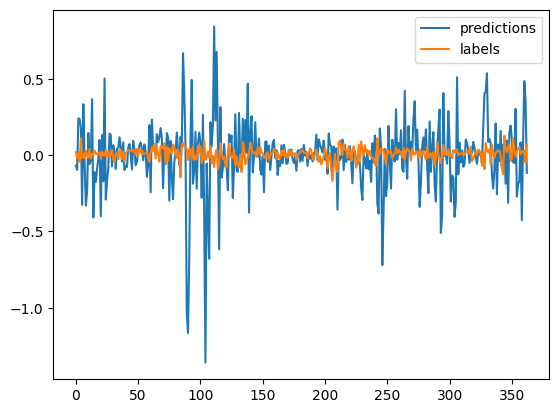

In [5]:
# import linear regression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# define the data to train on
data = sp500

# Drop rows with NaN values introduced by shifting
data.dropna(inplace=True)

# Define the window size for the rolling regression
window_size = 60

# Perform the rolling regression
results = []
predictions = []
for i in tqdm(range(len(data) - window_size)):
    #print("i:i+window_size = ", i, i+window_size)
    window_data = data.iloc[i:i+window_size]
    model = sm.OLS(window_data.iloc[:, 0], window_data.iloc[:, 1:])
    result = model.fit()
    results.append(result)
    predictions.append(result.predict(data.iloc[i+window_size, 1:]))
    
plt.plot(np.array(predictions), label="predictions")
plt.plot(np.array(data.Return[60:]), label="labels")
plt.legend()

In [6]:
mse = np.mean((np.array(predictions) - np.array(data.Return[60:]))**2)
print("The MSE for the rolling regression:", mse)

The MSE for the rolling regression: 0.051949809272433575


In [16]:
print(len(predictions), len(np.array(data.Return[60:])))

363 363
